In [21]:
import pandas as pd
import numpy as np
import json
import math
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


In [22]:
VIDEO_CSV_PATH = "video_data.json"
CATEGORIES_JSON_PATH = "video_categories.json"
CHANNEL_JSON_PATH = "channel_data (1).json"


In [23]:
video_raw = pd.read_json(VIDEO_CSV_PATH, lines=True)
print("Video data shape:", video_raw.shape)
display(video_raw.head())

with open(CATEGORIES_JSON_PATH, "r", encoding="utf-8") as f:
    categories_raw = json.load(f)

print("Category JSON keys:", categories_raw.keys())
print("Number of category items:", len(categories_raw.get("items", [])))

cat_map = {
    int(item["id"]): item["snippet"]["title"]
    for item in categories_raw["items"]
}
with open(CHANNEL_JSON_PATH, "r", encoding="utf-8") as f:
    channel_list = json.load(f)

channel_df = pd.DataFrame(channel_list)
print("Channel data shape:", channel_df.shape)
display(channel_df.head())

Video data shape: (440772, 13)


,channel_id,channel_title,video_id,category_id,published_at,title,description,thumbnail,view_count,like_count,favorite_count,comment_count,tags
0,UCYIvQrhDDhRE8MzS7eRrPsQ,A3,3niQ1dJcqFg,1,2021-08-14 05:51:05+00:00,Los Angeles street art,Taking a look at Los Angeles graffiti and mura...,https://i.ytimg.com/vi/3niQ1dJcqFg/default.jpg,11.0,1.0,0,0.0,NaN
1,UCYIvQrhDDhRE8MzS7eRrPsQ,A3,51b-1WotLww,1,2021-08-06 04:17:37+00:00,Los Angeles street art # graffiti # bomber,Taking a look at Los Angeles street art \n@ gr...,https://i.ytimg.com/vi/51b-1WotLww/default.jpg,13.0,2.0,0,0.0,NaN
2,UCgOGQK5_1x6GDxvhnOQdqeA,CF,jd2B6rH--tg,1,2021-02-09 20:09:05+00:00,The infinite bicycle,A favorite scene from the movie In The Mouth o...,https://i.ytimg.com/vi/jd2B6rH--tg/default.jpg,15321.0,175.0,0,29.0,"In The Mouth of Madness,John Carpenter,Horror"
3,UCsEukrAd64fqA7FjwkmZ_Dw,GQ,TRGHIN2PGIA,1,2022-10-05 16:00:12+00:00,Christian Bale Breaks Down His Most Iconic Cha...,Christian Bale breaks down a few of his most i...,https://i.ytimg.com/vi/TRGHIN2PGIA/default.jpg,15569853.0,457300.0,0,18103.0,"american psycho,amsterdam,celebrity,christian ..."
4,UCF3qBBXKBFkT6ykYlEZh6Gw,A K,VqDRhf1UpvE,1,2012-03-14 20:21:25+00:00,Smart Card (2005),Smartcard is a story about a man who realizes ...,https://i.ytimg.com/vi/VqDRhf1UpvE/default.jpg,29366.0,293.0,0,29.0,"card,id,identity,technology,future,short film,..."


Category JSON keys: dict_keys(['kind', 'etag', 'items'])
Number of category items: 32
Channel data shape: (1561, 11)


,channel_id,channel_title,description,custom_url,created_at,thumbnail,country,view_count,subscriber_count,hidden_subscribers,video_count
0,UC6sfgGx5u8qCpWeqMxFWpjQ,Crypto Trade1,Cryptotrade1 is basically providing trading si...,@cryptotrade1,2017-11-14T07:12:04Z,https://yt3.ggpht.com/vR-Cl98vUxtqxKOOh9YwDC7_...,AE,32872,1140,false,376
1,UCwQp7Wc1NIKrW4UTOgOmVKg,The Meaning Of Islam,"Assalam Alaikum!\nI’m Ayesha, the creator of “...",@themeaningofislam,2011-10-26T09:33:39Z,https://yt3.ggpht.com/ytc/AGIKgqP8TvqgrQpOpLiT...,AE,88557098,503000,false,121
2,UCZ245tjtaxNCb0Y4i9H9AXQ,Fernando Romero Moreno,Por un Frente Nacional que defienda los valore...,@fernandoromeromoreno1519,2014-07-28T20:45:20Z,https://yt3.ggpht.com/ytc/AGIKgqPe8zceaOY-88SQ...,AR,15661,666,false,47
3,UCNDrlU4YJrjPwO0yB7SG-bg,Ojo de Halcón,None,@ojodehalcon,2017-09-11T03:18:17Z,https://yt3.ggpht.com/ytc/AGIKgqPj3rmRbMVZ_gmt...,AR,28714333,94400,false,3312
4,UCFHAPATvu8q49hy53VPv6SA,Red Internacional de Promotores ODS,Canal Oficial de videos de la Red Internaciona...,@redinternacionaldepromotor7015,2020-02-22T17:10:07.38079Z,https://yt3.ggpht.com/ytc/AGIKgqOnCTiIM6cdyLSV...,AR,103219,5940,false,139


In [25]:
video_df = video_raw.copy()
video_df["category_title"] = video_df["category_id"].map(cat_map)
video_df["published_at"] = pd.to_datetime(video_df["published_at"], errors="coerce")
video_df["published_year"] = video_df["published_at"].dt.year
for col in ["view_count", "like_count", "favorite_count", "comment_count"]:
    video_df[col] = pd.to_numeric(video_df[col], errors="coerce")
video_df["like_count"] = video_df["like_count"].fillna(0)
video_df["comment_count"] = video_df["comment_count"].fillna(0)
video_df["like_rate"] = video_df["like_count"] / video_df["view_count"]
video_df["comment_rate"] = video_df["comment_count"] / video_df["view_count"]

print("Cleaned data shape:", video_df.shape)
display(video_df.head())

Cleaned data shape: (440772, 17)


,channel_id,channel_title,video_id,category_id,published_at,title,description,thumbnail,view_count,like_count,favorite_count,comment_count,tags,category_title,published_year,like_rate,comment_rate
0,UCYIvQrhDDhRE8MzS7eRrPsQ,A3,3niQ1dJcqFg,1,2021-08-14 05:51:05+00:00,Los Angeles street art,Taking a look at Los Angeles graffiti and mura...,https://i.ytimg.com/vi/3niQ1dJcqFg/default.jpg,11.0,1.0,0,0.0,NaN,Film & Animation,2021,0.090909,0.000000
1,UCYIvQrhDDhRE8MzS7eRrPsQ,A3,51b-1WotLww,1,2021-08-06 04:17:37+00:00,Los Angeles street art # graffiti # bomber,Taking a look at Los Angeles street art \n@ gr...,https://i.ytimg.com/vi/51b-1WotLww/default.jpg,13.0,2.0,0,0.0,NaN,Film & Animation,2021,0.153846,0.000000
2,UCgOGQK5_1x6GDxvhnOQdqeA,CF,jd2B6rH--tg,1,2021-02-09 20:09:05+00:00,The infinite bicycle,A favorite scene from the movie In The Mouth o...,https://i.ytimg.com/vi/jd2B6rH--tg/default.jpg,15321.0,175.0,0,29.0,"In The Mouth of Madness,John Carpenter,Horror",Film & Animation,2021,0.011422,0.001893
3,UCsEukrAd64fqA7FjwkmZ_Dw,GQ,TRGHIN2PGIA,1,2022-10-05 16:00:12+00:00,Christian Bale Breaks Down His Most Iconic Cha...,Christian Bale breaks down a few of his most i...,https://i.ytimg.com/vi/TRGHIN2PGIA/default.jpg,15569853.0,457300.0,0,18103.0,"american psycho,amsterdam,celebrity,christian ...",Film & Animation,2022,0.029371,0.001163
4,UCF3qBBXKBFkT6ykYlEZh6Gw,A K,VqDRhf1UpvE,1,2012-03-14 20:21:25+00:00,Smart Card (2005),Smartcard is a story about a man who realizes ...,https://i.ytimg.com/vi/VqDRhf1UpvE/default.jpg,29366.0,293.0,0,29.0,"card,id,identity,technology,future,short film,...",Film & Animation,2012,0.009978,0.000988


In [26]:
df_ml = video_df[["view_count", "like_count", "comment_count", "category_title"]].copy()
df_ml = df_ml[df_ml["view_count"] > 0]

y = np.log1p(df_ml["view_count"].values)

X_numeric = df_ml[["like_count", "comment_count"]]
X_cat = pd.get_dummies(df_ml["category_title"], prefix="cat", drop_first=True)

X = pd.concat([X_numeric, X_cat], axis=1)

print("Feature matrix shape:", X.shape)
print("Target vector shape:", y.shape)
X.head()


Feature matrix shape: (439816, 17)
Target vector shape: (439816,)


,like_count,comment_count,cat_Comedy,cat_Education,cat_Entertainment,cat_Film & Animation,cat_Gaming,cat_Howto & Style,cat_Music,cat_News & Politics,cat_Nonprofits & Activism,cat_People & Blogs,cat_Pets & Animals,cat_Science & Technology,cat_Sports,cat_Trailers,cat_Travel & Events
0,1.0,0.0,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
1,2.0,0.0,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
2,175.0,29.0,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
3,457300.0,18103.0,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
4,293.0,29.0,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False


In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report

eng_df = video_df.dropna(subset=["like_rate"]).copy()
q3 = eng_df["like_rate"].quantile(0.75)
eng_df["high_engagement"] = (eng_df["like_rate"] >= q3).astype(int)

X_eng_num = eng_df[["like_count", "comment_count"]].fillna(0)
X_eng_cat = pd.get_dummies(eng_df["category_title"], prefix="cat", drop_first=True)
X_eng = pd.concat([X_eng_num, X_eng_cat], axis=1)
y_eng = eng_df["high_engagement"].values

X_train_eng, X_test_eng, y_train_eng, y_test_eng = train_test_split(
    X_eng, y_eng, test_size=0.2, random_state=42, stratify=y_eng
)

log_clf = LogisticRegression(
    penalty="l2",
    solver="liblinear",
    max_iter=1000,
    class_weight="balanced"
)
log_clf.fit(X_train_eng, y_train_eng)

y_pred_eng = log_clf.predict(X_test_eng)

print("Accuracy:", accuracy_score(y_test_eng, y_pred_eng))
print("Precision:", precision_score(y_test_eng, y_pred_eng))
print("Recall:", recall_score(y_test_eng, y_pred_eng))
print(classification_report(y_test_eng, y_pred_eng, digits=3))


Accuracy: 0.6908001682410849
Precision: 0.060432140445644836
Recall: 0.01627864678064751
              precision    recall  f1-score   support

           0      0.736     0.916     0.816     65977
           1      0.060     0.016     0.026     21992

    accuracy                          0.691     87969
   macro avg      0.398     0.466     0.421     87969
weighted avg      0.567     0.691     0.619     87969



In [29]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

df_ml_lasso = video_df[["view_count", "like_count", "comment_count", "category_title"]].copy()
df_ml_lasso = df_ml_lasso[df_ml_lasso["view_count"] > 0]

y_lasso = np.log1p(df_ml_lasso["view_count"].values)
X_num_lasso = df_ml_lasso[["like_count", "comment_count"]].fillna(0)
X_cat_lasso = pd.get_dummies(df_ml_lasso["category_title"], prefix="cat", drop_first=True)
X_lasso = pd.concat([X_num_lasso, X_cat_lasso], axis=1)

scaler_lasso = StandardScaler()
X_lasso_scaled = scaler_lasso.fit_transform(X_lasso)

lasso = Lasso(alpha=0.001, max_iter=10000)
lasso.fit(X_lasso_scaled, y_lasso)

coef_series = pd.Series(lasso.coef_, index=X_lasso.columns)
non_zero = coef_series[coef_series != 0].sort_values(key=abs, ascending=False)

print(non_zero)
print("Number of non-zero features:", len(non_zero))


like_count                   0.887719
cat_Music                    0.812442
cat_People & Blogs          -0.614659
cat_Gaming                  -0.498472
cat_Comedy                   0.214560
cat_Nonprofits & Activism   -0.184915
cat_Travel & Events         -0.167090
comment_count               -0.162834
cat_Howto & Style           -0.137461
cat_Film & Animation         0.114099
cat_News & Politics          0.113268
cat_Education               -0.109725
cat_Science & Technology    -0.080217
cat_Pets & Animals          -0.058366
cat_Trailers                 0.018352
cat_Sports                  -0.017675
cat_Entertainment           -0.016828
dtype: float64
Number of non-zero features: 17


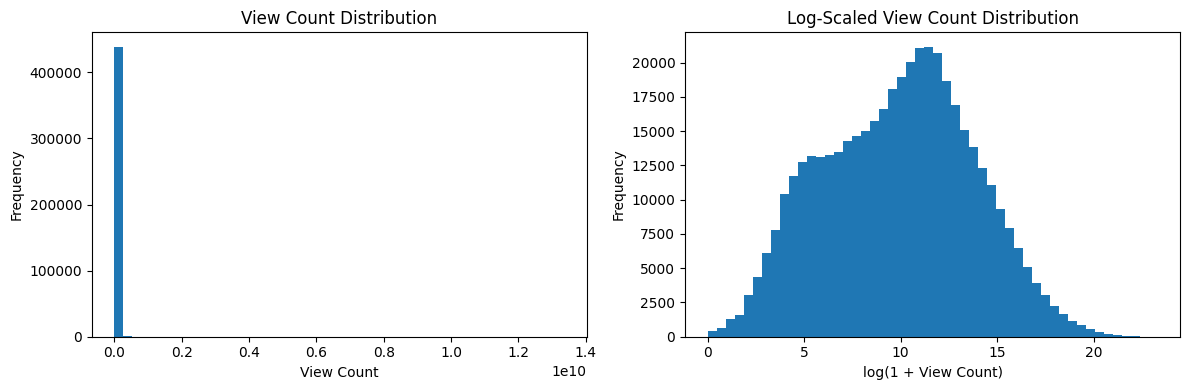

In [30]:
import matplotlib.pyplot as plt

views = video_df["view_count"].dropna()

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(views, bins=50)
plt.xlabel("View Count")
plt.ylabel("Frequency")
plt.title("View Count Distribution")

plt.subplot(1, 2, 2)
plt.hist(np.log1p(views), bins=50)
plt.xlabel("log(1 + View Count)")
plt.ylabel("Frequency")
plt.title("Log-Scaled View Count Distribution")

plt.tight_layout()
plt.show()


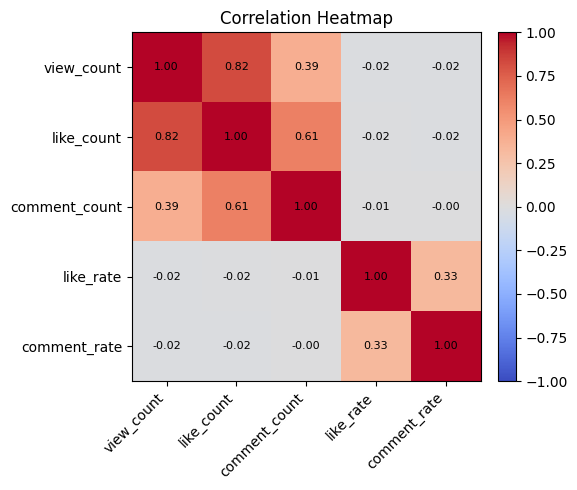

In [31]:
metrics_cols = ["view_count", "like_count", "comment_count", "like_rate", "comment_rate"]
corr_matrix = video_df[metrics_cols].corr()

plt.figure(figsize=(6, 5))
im = plt.imshow(corr_matrix, cmap="coolwarm", vmin=-1, vmax=1)
plt.colorbar(im, fraction=0.046, pad=0.04)

plt.xticks(range(len(metrics_cols)), metrics_cols, rotation=45, ha="right")
plt.yticks(range(len(metrics_cols)), metrics_cols)
plt.title("Correlation Heatmap")

for i in range(len(metrics_cols)):
    for j in range(len(metrics_cols)):
        plt.text(j, i, f"{corr_matrix.iloc[i, j]:.2f}", ha="center", va="center", fontsize=8)

plt.tight_layout()
plt.show()


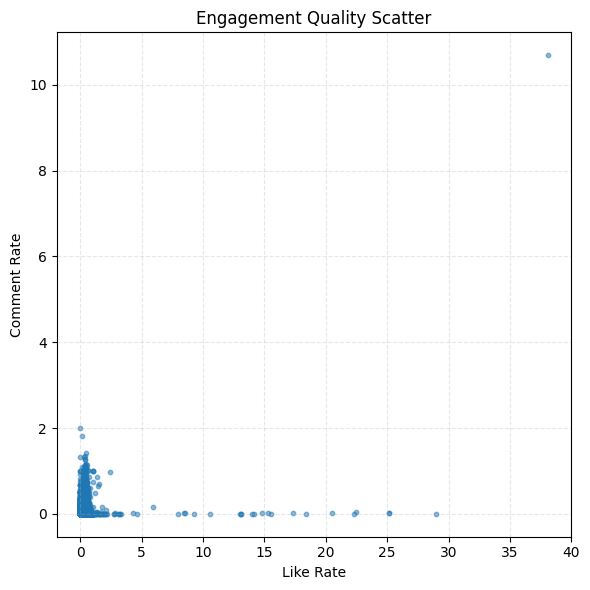

In [32]:
like_rate = video_df["like_rate"]
comment_rate = video_df["comment_rate"]

mask = (~like_rate.isna()) & (~comment_rate.isna())
lr = like_rate[mask]
cr = comment_rate[mask]

plt.figure(figsize=(6, 6))

if "engagement_cluster" in video_df.columns:
    clusters = video_df.loc[mask, "engagement_cluster"]
    for c in sorted(clusters.dropna().unique()):
        cmask = (clusters == c)
        plt.scatter(lr[cmask], cr[cmask], s=10, alpha=0.5, label=f"Cluster {int(c)}")
    plt.legend()
else:
    plt.scatter(lr, cr, s=10, alpha=0.5)

plt.xlabel("Like Rate")
plt.ylabel("Comment Rate")
plt.title("Engagement Quality Scatter")
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()
